In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive

drive.mount("/content/drive")

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "cs231n/assignments/assignment2/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys

sys.path.append("/content/drive/My Drive/{}".format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment2


ローカルで実行する場合

In [1]:
%cd ./cs231n/datasets/
!bash get_datasets.sh
%cd ../../

/workspaces/cs231n/src/assignment2/cs231n/datasets
/workspaces/cs231n/src/assignment2


# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

この演習では、任意の数の隠れ層を持つ完全連結ネットワークを実装する。

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.

ファイル `cs231n/classifiers/fc_net.py` にある `FullyConnectedNet` クラスを読み込む。

ネットワークの初期化、フォワードパス、バックワードパスを実装する。この課題では、`cs231n/layers.py` でレイヤーを実装します。課題1で実装した `affine_forward`、`affine_backward`、`relu_forward`、`relu_backward`、`softmax_loss` を再利用できます。今のところ、ドロップアウトやバッチ/レイヤーの正規化の実装についてはまだ心配しないでください。


In [2]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import FullyConnectedNet
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2


def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

正統性チェックとして、初期損失をチェックし、正則化の有無にかかわらずネットワークを勾配チェックするために以下を実行する。これは初期損失が妥当かどうかを確認する良い方法です。

勾配チェックでは、1e-7かそれ以下の誤差を期待してください。

In [4]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64,
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # ほとんどの誤差はe-7かそれ以下であるはずだ。
    # 注：reg = 0.0の場合、W2のチェックでe-5のオーダーでエラーが表示されるのは問題ない。
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.0252674471656573e-07
W2 relative error: 2.2120479295080622e-05
W3 relative error: 4.5623278736665505e-07
b1 relative error: 4.6600944653202505e-09
b2 relative error: 2.085654276112763e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 6.862884860440611e-09
W2 relative error: 3.522821562176466e-08
W3 relative error: 2.6171457283983532e-08
b1 relative error: 1.4752427965311745e-08
b2 relative error: 1.7223751746766738e-09
b3 relative error: 2.378772438198909e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

もう1つの健全性チェックとして、ネットワークが50画像の小さなデータセットでオーバーフィットできることを確認する。まず、各隠れ層に100ユニットを持つ3層ネットワークを試してみます。次のセルで、オーバーフィットして20エポック以内に100%のトレーニング精度を達成するために、**学習率**と**ウェイト初期化スケール**を微調整します。

(Iteration 1 / 40) loss: 9.817983
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.116000
(Epoch 1 / 20) train acc: 0.400000; val_acc: 0.132000
(Epoch 2 / 20) train acc: 0.640000; val_acc: 0.133000
(Epoch 3 / 20) train acc: 0.860000; val_acc: 0.148000
(Epoch 4 / 20) train acc: 0.900000; val_acc: 0.163000
(Epoch 5 / 20) train acc: 0.960000; val_acc: 0.165000
(Iteration 11 / 40) loss: 0.099653
(Epoch 6 / 20) train acc: 0.960000; val_acc: 0.164000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.173000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.167000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.165000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.167000
(Iteration 21 / 40) loss: 0.052787
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.164000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.166000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.166000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.171000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.166000
(Iteration 31 / 40) loss: 

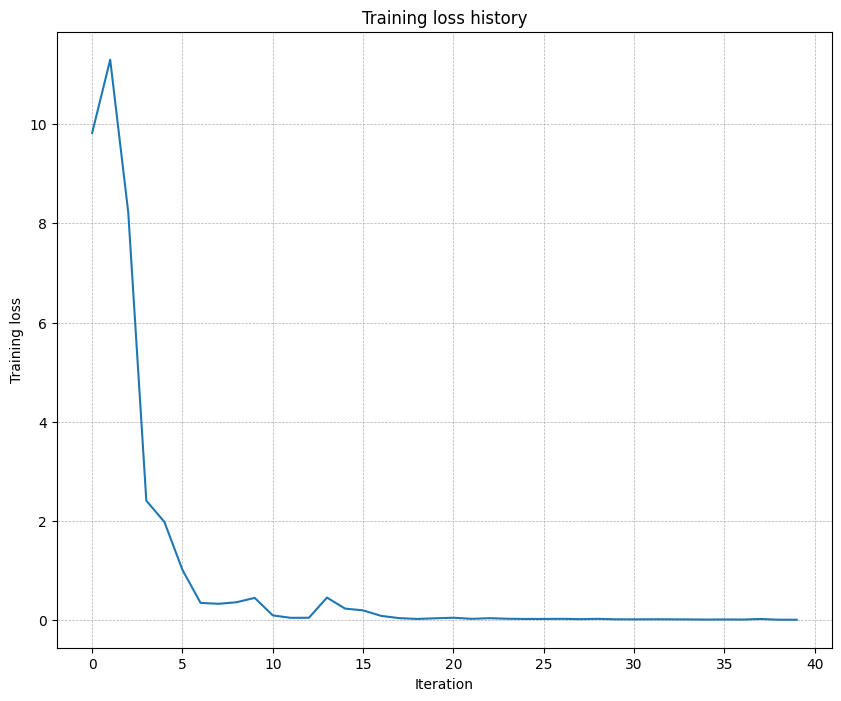

In [5]:
# TODO: 3層ネットを使って、学習率と初期化スケールだけを微調整することで、
# 50のトレーニング例をオーバーフィットさせる。

num_train = 50
small_data = {
    "X_train": data["X_train"][:num_train],
    "y_train": data["y_train"][:num_train],
    "X_val": data["X_val"],
    "y_val": data["y_val"],
}

weight_scale = 3e-2  # 実験してみよう！
learning_rate = 4e-3  # 実験してみよう！
model = FullyConnectedNet([100, 100], weight_scale=weight_scale, dtype=np.float64)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle="--", linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

今度は、各レイヤーに100ユニットを持つ5レイヤーネットワークを使って、50のトレーニング例でオーバーフィットさせてみよう。ここでも学習率と重みの初期化スケールを調整する必要があるが、20エポック以内に100％の学習精度を達成できるはずだ。

(Iteration 1 / 40) loss: 54.581332
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.111000
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.087000
(Epoch 2 / 20) train acc: 0.280000; val_acc: 0.115000
(Epoch 3 / 20) train acc: 0.540000; val_acc: 0.130000
(Epoch 4 / 20) train acc: 0.700000; val_acc: 0.133000
(Epoch 5 / 20) train acc: 0.800000; val_acc: 0.117000
(Iteration 11 / 40) loss: 0.737084
(Epoch 6 / 20) train acc: 0.880000; val_acc: 0.129000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.138000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.135000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.134000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.131000
(Iteration 21 / 40) loss: 0.092505
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.132000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.129000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.130000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.129000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.129000
(Iteration 31 / 40) loss:

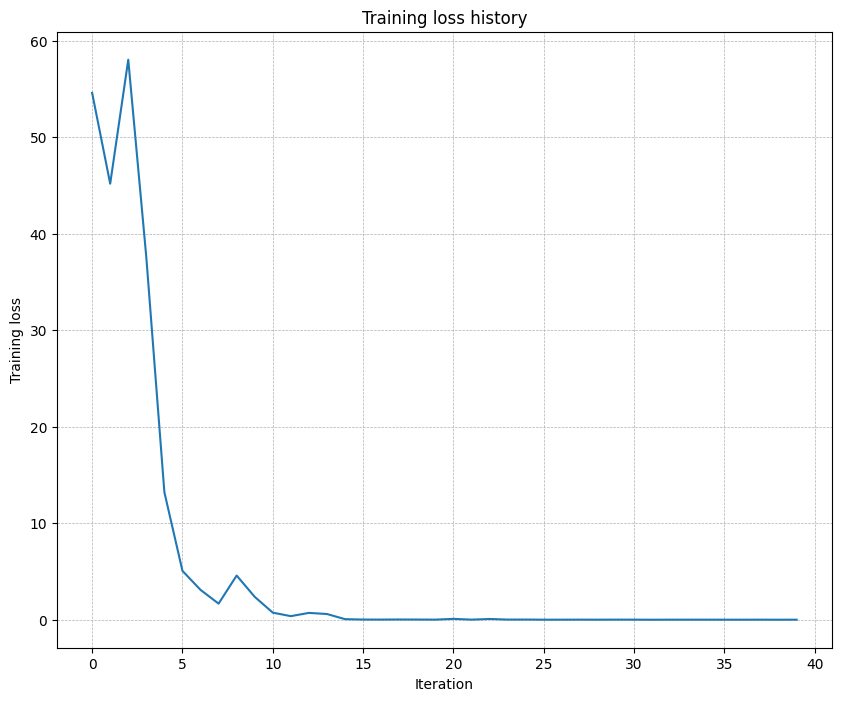

In [6]:
# TODO: 5層ネットを使って、学習率と初期化スケールだけを微調整することで、50の学習例をオーバーフィットさせる。

num_train = 50
small_data = {
    "X_train": data["X_train"][:num_train],
    "y_train": data["y_train"][:num_train],
    "X_val": data["X_val"],
    "y_val": data["y_val"],
}

learning_rate = 3e-3  # 実験してみよう！
weight_scale = 8e-2  # 実験してみよう！
model = FullyConnectedNet(
    [100, 100, 100, 100], weight_scale=weight_scale, dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle="--", linewidth=0.5)
plt.show()

## Inline Question 1: 
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

3層ネットワークの訓練と5層ネットワークの訓練の難しさについて、何かお気づきになりましたか？特に、あなたの経験に基づいて、どちらのネットワークが初期化スケールに敏感だと思われましたか？それはなぜだと思いますか？

Answer:

注目すべきは、エポックごとの精度向上がウェイトの初期化に依存するため、_5-layer_ ネットワークは学習がより困難であるということである。したがって、_5-layer_ ネットワークは初期化の規模に対してより敏感である。

平均して、異なる学習率において、高い（`>0.8`）精度を持つ範囲（各精度は特定の重みスケールに依存する）は、_3-layer_ netwrokの方が大きい。これは、ネットワークが高精度に収束するために、特定の重みスケールの値を見つけるために必要な労力が少ないことを意味します。したがって、重みスケールが3層ネットワークに与える影響は小さい。



In [7]:
from tabulate import tabulate

# 学習率と重みの定義
learning_rates = [5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
weight_scales = [
    0.75e-4,
    1e-3,
    *np.linspace(2.5e-3, 0.01, 4),
    *np.linspace(2.5e-2, 0.1, 4),
    0.25,
    0.5,
]

# 各学習率と重みスケールの精度の一覧表
accs_3_layer = []
accs_5_layer = []

for ws in weight_scales:
    # 重みスケールで初期化する
    ws_per_lr_1 = [ws]
    ws_per_lr_2 = [ws]

    for lr in learning_rates:
        # 3層と5層のネットワークの定義
        model_3_layer = FullyConnectedNet([100] * 2, weight_scale=ws, dtype=np.float64)
        model_5_layer = FullyConnectedNet([100] * 4, weight_scale=ws, dtype=np.float64)

        # 3層モデルのソルバーを定義する
        solver_1 = Solver(
            model_3_layer,
            small_data,
            num_epochs=20,
            batch_size=25,
            optim_config={"learning_rate": lr},
            verbose=False,
        )

        # 5層モデルのソルバーを定義する
        solver_2 = Solver(
            model_5_layer,
            small_data,
            num_epochs=20,
            batch_size=25,
            optim_config={"learning_rate": lr},
            verbose=False,
        )

        # ソルバーを使って両方のモデルをトレーニングする
        solver_1.train()
        solver_2.train()

        # 最も高いトレーシング精度を含むエポック
        first_best_1 = np.argmax(solver_1.train_acc_history)
        first_best_2 = np.argmax(solver_2.train_acc_history)

        # 最も精度の高いエポックと、丸めた精度のタプルを追加する。
        ws_per_lr_1.append(
            (int(first_best_1), round(solver_1.train_acc_history[first_best_1], 2))
        )
        ws_per_lr_2.append(
            (int(first_best_2), round(solver_2.train_acc_history[first_best_2], 2))
        )

        # 低精度がしばらく変わらなかった場合は、勾配の消滅を考慮すること
        if first_best_1 < 14 and ws_per_lr_1[-1][1] < 0.7:
            ws_per_lr_1[-1] = "vanished"

        if first_best_2 < 14 and ws_per_lr_2[-1][1] < 0.7:
            ws_per_lr_2[-1] = "vanished"

        # 勾配更新中にNaN値が導入された場合、勾配の爆発を考慮する。
        if np.isnan(solver_1.loss_history[-1]):
            ws_per_lr_1[-1] = "exploded"

        if np.isnan(solver_2.loss_history[-1]):
            ws_per_lr_2[-1] = "exploded"

    # 各学習率の精度のリストを追加する。
    accs_3_layer.append(ws_per_lr_1)
    accs_5_layer.append(ws_per_lr_2)

# 各ウェイトスケールの精度を示す2つの表（3層および5層ネット用）を印刷する。
print("\nBest accuracies and the number of epochs taken to reach it")
print("\n##### 3-layer net: (epoch, accuracy) #####\n")
print(tabulate(accs_3_layer, headers=["ws/lr", *learning_rates]))
print("\n##### 5-layer net: (epoch, accuracy) #####\n")
print(tabulate(accs_5_layer, headers=["ws/lr", *learning_rates]))

/workspaces/cs231n/src/assignment2/cs231n/layers.py:147: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(P[range(N), y]).sum() / N     # sum cross entropies as loss
/workspaces/cs231n/src/assignment2/cs231n/layers.py:28: RuntimeWarning: overflow encountered in matmul
  out = x.reshape(len(x), -1) @ w + b
/workspaces/cs231n/src/assignment2/cs231n/classifiers/fc_net.py:198: RuntimeWarning: overflow encountered in square
  loss += 0.5 * self.reg * np.sum([np.sum(W**2) for k, W in self.params.items() if 'W' in k])
/workspaces/cs231n/src/assignment2/cs231n/classifiers/fc_net.py:198: RuntimeWarning: invalid value encountered in scalar multiply
  loss += 0.5 * self.reg * np.sum([np.sum(W**2) for k, W in self.params.items() if 'W' in k])
/workspaces/cs231n/src/assignment2/cs231n/layers.py:28: RuntimeWarning: invalid value encountered in matmul
  out = x.reshape(len(x), -1) @ w + b
/workspaces/cs231n/src/assignment2/cs231n/layers.py:144: RuntimeWarning: invalid value encounte


Best accuracies and the number of epochs taken to reach it

##### 3-layer net: (epoch, accuracy) #####

  ws/lr  5e-06       1e-05       5e-05       0.0001      0.0005      0.001       0.005       0.01
-------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
7.5e-05  vanished    vanished    vanished    vanished    vanished    vanished    vanished    vanished
0.001    vanished    vanished    vanished    vanished    vanished    vanished    (17, 0.2)   vanished
0.0025   vanished    vanished    vanished    vanished    (17, 0.3)   (19, 0.32)  (18, 0.34)  (19, 0.48)
0.005    vanished    vanished    vanished    (20, 0.18)  (20, 0.3)   (17, 0.38)  (18, 0.64)  (18, 0.9)
0.0075   vanished    vanished    (20, 0.06)  vanished    (19, 0.46)  (18, 0.56)  (20, 0.94)  (19, 1.0)
0.01     vanished    (20, 0.16)  vanished    (18, 0.1)   (19, 0.42)  (19, 0.6)   (15, 1.0)   (11, 1.0)
0.025    vanished    vanished    (19, 0.32)  (18, 0.52)  (15, 0.96)  (13, 1.

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

これまでのところ、更新ルールとしてバニラ確率勾配降下法（SGD）を使用してきた。より洗練された更新ルールを使えば、ディープネットワークの学習が容易になる。ここでは、最も一般的に使用される更新ルールをいくつか実装し、バニラSGDと比較する。

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

モメンタム付き確率的勾配降下は、ディープ・ネットワークを通常の確率的勾配降下よりも高速に収束させる傾向がある、広く使われている更新ルールです。詳しくは http://cs231n.github.io/neural-networks-3/#sgd のモメンタム更新のセクションを参照。

`cs231n/optim.py`を開き、ファイルの一番上にあるドキュメントを読んで、APIを理解していることを確認してください。関数 `sgd_momentum` で SGD+momentum 更新ルールを実装し、実装をチェックするために以下を実行します。e-8 未満のエラーが表示されるはずである。

In [8]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N * D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N * D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N * D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray(
    [
        [0.1406, 0.20738947, 0.27417895, 0.34096842, 0.40775789],
        [0.47454737, 0.54133684, 0.60812632, 0.67491579, 0.74170526],
        [0.80849474, 0.87528421, 0.94207368, 1.00886316, 1.07565263],
        [1.14244211, 1.20923158, 1.27602105, 1.34281053, 1.4096],
    ]
)
expected_velocity = np.asarray(
    [
        [0.5406, 0.55475789, 0.56891579, 0.58307368, 0.59723158],
        [0.61138947, 0.62554737, 0.63970526, 0.65386316, 0.66802105],
        [0.68217895, 0.69633684, 0.71049474, 0.72465263, 0.73881053],
        [0.75296842, 0.76712632, 0.78128421, 0.79544211, 0.8096],
    ]
)

# 相対誤差はe-8以下になるはず
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

それができたら、以下を実行して、SGDとSGD+momentumの両方で6層ネットワークを訓練します。SGD+momentumの更新ルールの方が早く収束することがわかるはずです。

Running with  sgd
(Iteration 1 / 200) loss: 2.433510
(Epoch 0 / 5) train acc: 0.117000; val_acc: 0.130000
(Iteration 11 / 200) loss: 2.281262
(Iteration 21 / 200) loss: 2.257696
(Iteration 31 / 200) loss: 2.248852
(Epoch 1 / 5) train acc: 0.245000; val_acc: 0.198000
(Iteration 41 / 200) loss: 2.177328
(Iteration 51 / 200) loss: 2.113083
(Iteration 61 / 200) loss: 2.095447
(Iteration 71 / 200) loss: 1.932167
(Epoch 2 / 5) train acc: 0.255000; val_acc: 0.270000
(Iteration 81 / 200) loss: 2.049039
(Iteration 91 / 200) loss: 2.006367
(Iteration 101 / 200) loss: 1.991786
(Iteration 111 / 200) loss: 1.878708
(Epoch 3 / 5) train acc: 0.309000; val_acc: 0.284000
(Iteration 121 / 200) loss: 1.916883
(Iteration 131 / 200) loss: 1.939414
(Iteration 141 / 200) loss: 1.784271
(Iteration 151 / 200) loss: 1.883084
(Epoch 4 / 5) train acc: 0.363000; val_acc: 0.314000
(Iteration 161 / 200) loss: 1.931785
(Iteration 171 / 200) loss: 1.799524
(Iteration 181 / 200) loss: 1.770144
(Iteration 191 / 200) los

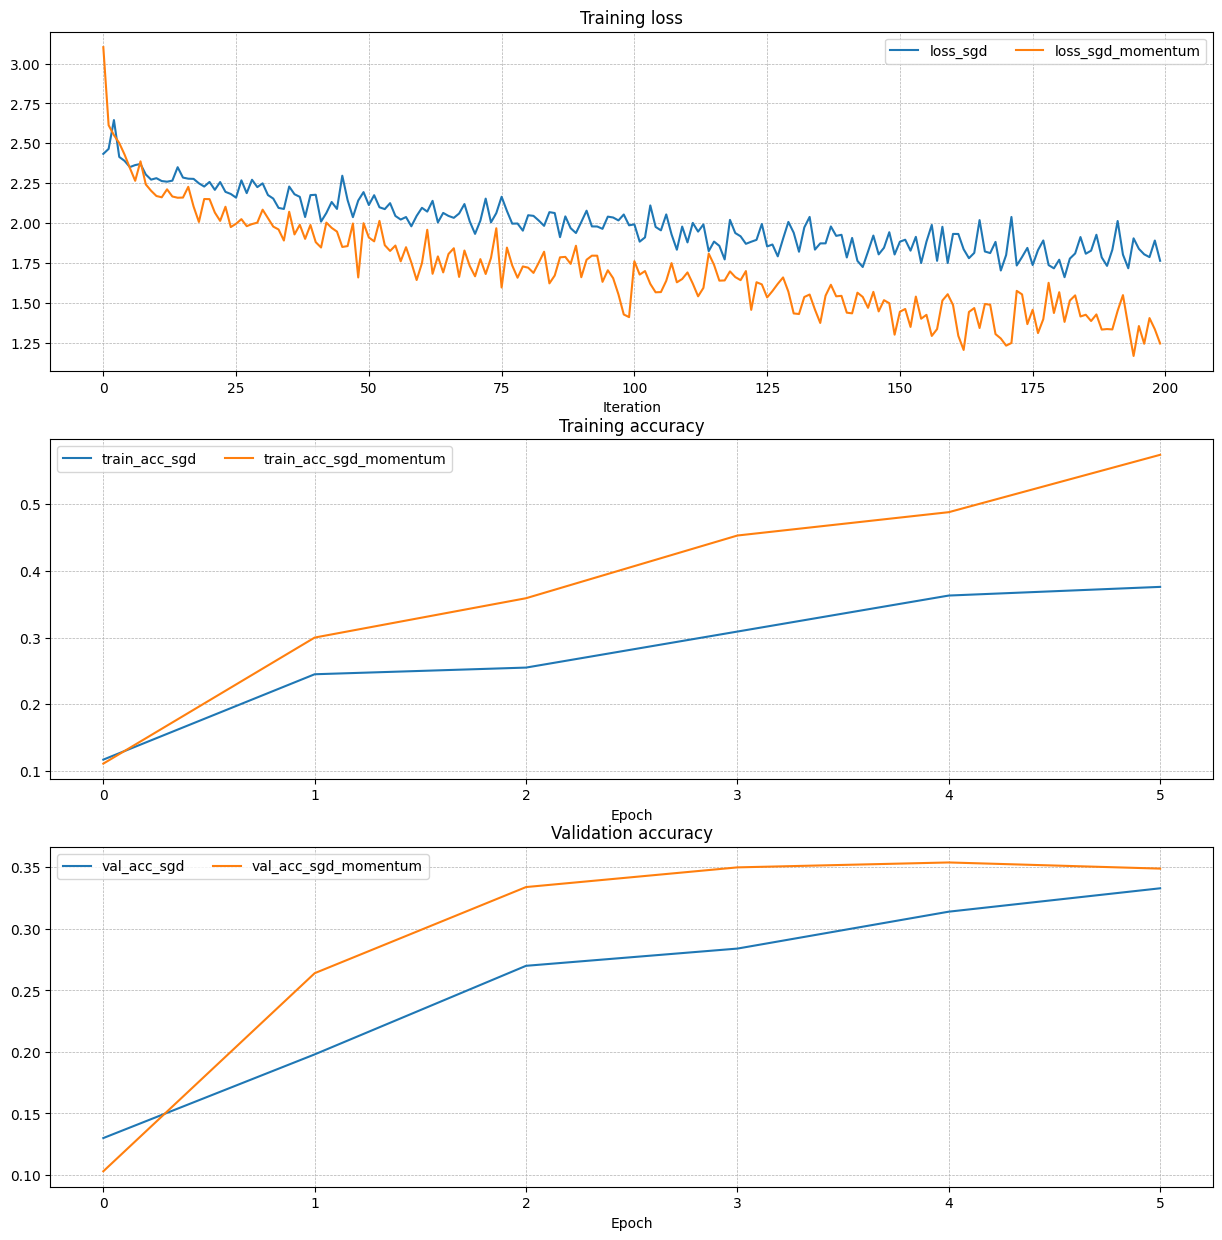

In [9]:
num_train = 4000
small_data = {
    "X_train": data["X_train"][:num_train],
    "y_train": data["y_train"][:num_train],
    "X_val": data["X_val"],
    "y_val": data["y_val"],
}

solvers = {}

for update_rule in ["sgd", "sgd_momentum"]:
    print("Running with ", update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={"learning_rate": 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title("Training loss")
axes[0].set_xlabel("Iteration")
axes[1].set_title("Training accuracy")
axes[1].set_xlabel("Epoch")
axes[2].set_title("Validation accuracy")
axes[2].set_xlabel("Epoch")

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")

for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle="--", linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

RMSProp [1] と Adam [2] は、勾配の第二モーメントの実行平均を用いてパラメータ毎の学習率を設定する更新ルールである。

ファイル `cs231n/optim.py` の `rmsprop` 関数で RMSProp の更新ルールを実装し、`adam` 関数で Adam の更新ルールを実装します。

**注意:** コースのノートに記載されている最初の簡易版ではなく、(バイアス補正機構を備えた)完全なアダム更新ルールを実装してください。

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [10]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N * D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N * D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N * D).reshape(N, D)

config = {"learning_rate": 1e-2, "cache": cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray(
    [
        [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
        [-0.132737, -0.08078555, -0.02881884, 0.02316247, 0.07515774],
        [0.12716641, 0.17918792, 0.23122175, 0.28326742, 0.33532447],
        [0.38739248, 0.43947102, 0.49155973, 0.54365823, 0.59576619],
    ]
)
expected_cache = np.asarray(
    [
        [0.5976, 0.6126277, 0.6277108, 0.64284931, 0.65804321],
        [0.67329252, 0.68859723, 0.70395734, 0.71937285, 0.73484377],
        [0.75037008, 0.7659518, 0.78158892, 0.79728144, 0.81302936],
        [0.82883269, 0.84469141, 0.86060554, 0.87657507, 0.8926],
    ]
)

# You should see relative errors around e-7 or less
print("next_w error: ", rel_error(expected_next_w, next_w))
print("cache error: ", rel_error(expected_cache, config["cache"]))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [11]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N * D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N * D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N * D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N * D).reshape(N, D)

config = {"learning_rate": 1e-2, "m": m, "v": v, "t": 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray(
    [
        [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
        [-0.1380274, -0.08544591, -0.03286534, 0.01971428, 0.0722929],
        [0.1248705, 0.17744702, 0.23002243, 0.28259667, 0.33516969],
        [0.38774145, 0.44031188, 0.49288093, 0.54544852, 0.59801459],
    ]
)
expected_v = np.asarray(
    [
        [
            0.69966,
            0.68908382,
            0.67851319,
            0.66794809,
            0.65738853,
        ],
        [
            0.64683452,
            0.63628604,
            0.6257431,
            0.61520571,
            0.60467385,
        ],
        [
            0.59414753,
            0.58362676,
            0.57311152,
            0.56260183,
            0.55209767,
        ],
        [
            0.54159906,
            0.53110598,
            0.52061845,
            0.51013645,
            0.49966,
        ],
    ]
)
expected_m = np.asarray(
    [
        [0.48, 0.49947368, 0.51894737, 0.53842105, 0.55789474],
        [0.57736842, 0.59684211, 0.61631579, 0.63578947, 0.65526316],
        [0.67473684, 0.69421053, 0.71368421, 0.73315789, 0.75263158],
        [0.77210526, 0.79157895, 0.81105263, 0.83052632, 0.85],
    ]
)

# You should see relative errors around e-7 or less
print("next_w error: ", rel_error(expected_next_w, next_w))
print("v error: ", rel_error(expected_v, config["v"]))
print("m error: ", rel_error(expected_m, config["m"]))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

RMSPropとAdamの実装をデバッグしたら、以下を実行して、これらの新しい更新ルールを使って2つのディープネットワークを訓練する：

Running with  adam
(Iteration 1 / 200) loss: 2.890210
(Epoch 0 / 5) train acc: 0.134000; val_acc: 0.103000
(Iteration 11 / 200) loss: 2.108765
(Iteration 21 / 200) loss: 1.827374
(Iteration 31 / 200) loss: 1.830237
(Epoch 1 / 5) train acc: 0.387000; val_acc: 0.327000
(Iteration 41 / 200) loss: 1.880897
(Iteration 51 / 200) loss: 1.534664
(Iteration 61 / 200) loss: 1.729991
(Iteration 71 / 200) loss: 1.726208
(Epoch 2 / 5) train acc: 0.433000; val_acc: 0.358000
(Iteration 81 / 200) loss: 1.735433
(Iteration 91 / 200) loss: 1.383983
(Iteration 101 / 200) loss: 1.573490
(Iteration 111 / 200) loss: 1.326713
(Epoch 3 / 5) train acc: 0.510000; val_acc: 0.371000
(Iteration 121 / 200) loss: 1.383148
(Iteration 131 / 200) loss: 1.256936
(Iteration 141 / 200) loss: 1.308188
(Iteration 151 / 200) loss: 1.170671
(Epoch 4 / 5) train acc: 0.548000; val_acc: 0.386000
(Iteration 161 / 200) loss: 1.321688
(Iteration 171 / 200) loss: 1.329897
(Iteration 181 / 200) loss: 1.120232
(Iteration 191 / 200) lo

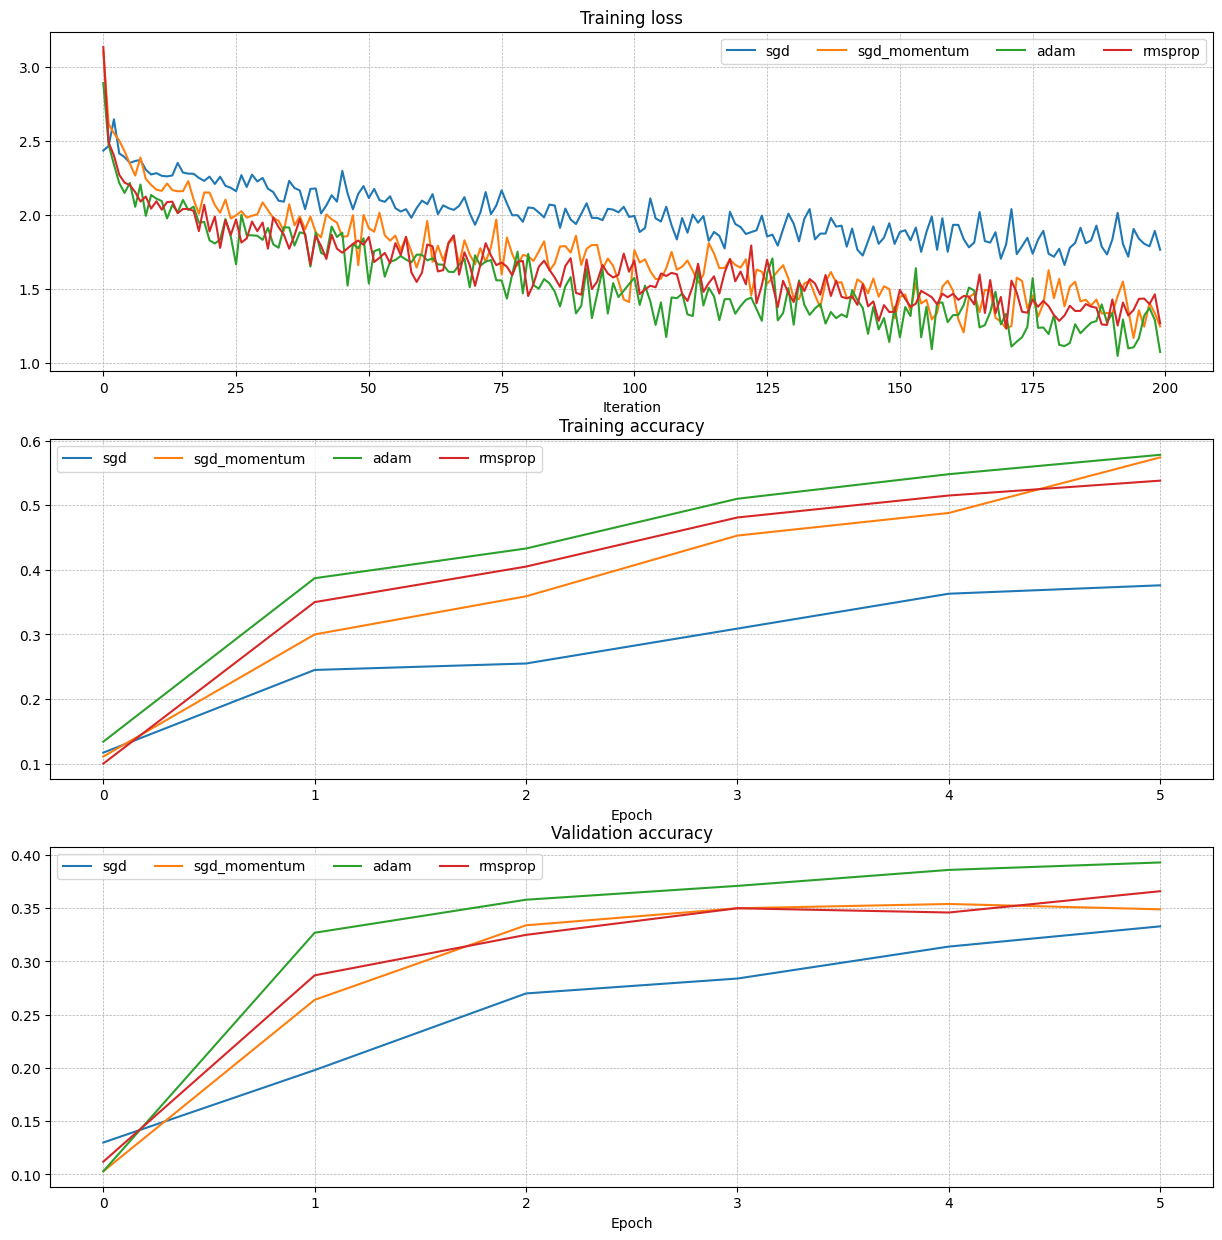

In [12]:
learning_rates = {"rmsprop": 1e-4, "adam": 1e-3}
for update_rule in ["adam", "rmsprop"]:
    print("Running with ", update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={"learning_rate": learning_rates[update_rule]},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()
    print()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title("Training loss")
axes[0].set_xlabel("Iteration")
axes[1].set_title("Training accuracy")
axes[1].set_xlabel("Epoch")
axes[2].set_title("Validation accuracy")
axes[2].set_xlabel("Epoch")

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")

for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle="--", linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

AdaGradは、Adamと同様、以下の更新ルールを使用するパラメータごとの最適化手法である：

```python
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?

Johnは、AdaGradでネットワークを訓練しているとき、更新が非常に小さくなり、ネットワークの学習が遅くなっていることに気づいた。AdaGradの更新ルールに関するあなたの知識を使って、なぜ更新が非常に小さくなると思いますか？アダムにも同じ問題があるでしょうか？

### Answer: 

**AdaGrad**でパラメータを更新する際には勾配をキャッシュ(勾配の二乗)の二乗根で割る。これにより高い勾配を持つパラメータは学習率が下がり、低い勾配を持つパラメータは学習率が上がる。

1. **AdaGrad**による小さな更新の理由
  * キャッシュが単調に成長するにつれて、より大きなキャッシュによって勾配を分割し、低い値を生成する。最小値へのステップが小さくなり、更新が非常に小さくなる可能性がある。凸の場合、最小値付近でのステップを小さくしたいので、これは良い機能であるが、非凸の場合、鞍点にはまり、それ以上の更新ができなくなる。

2. **アダム**の頑健性
  - **Adam**は、**RMSprop**と同様に、勾配の2乗推定値を減衰させるので、同じ問題は発生しません。加えて、**Momentum**更新ルールが組み込まれており、時間経過とともに速度を増加させることができるため、鞍点での極端な速度低下は起こらない。


# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

CIFAR-10 でできる限り最良の完全連結モデルを学習し、最良のモデルを `best_model` 変数に格納する。完全連結ネットワークを使って、検証セットで少なくとも50%の精度を得ることを要求します。

注意深くやれば、55%以上の精度を得ることは可能でしょうが、このパートではそれを要求しません。この課題の後半では、CIFAR-10 上で可能な限り最良の畳み込みネットワークを学習するよう求めますが、完全接続ネットワークよりも畳み込みネットワークに労力を費やすことを希望します。

**注意:** このパートを終える前に、`BatchNormalization.ipynb` と `Dropout.ipynb` のノートブックを完成させておくと便利です。

In [4]:
num_train = 500  # テスト用トレーニングデータ量

# 小規模データセットの作成
small_data = {
    "X_train": data["X_train"][:num_train],
    "y_train": data["y_train"][:num_train],
    "X_val": data["X_val"],
    "y_val": data["y_val"],
}

In [5]:
import time

best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
#                                                                              #
# CIFAR-10で最高のFullyConnectedNetをトレーニングしよう。
# バッチ/レイヤー正規化とドロップアウトが役に立つかもしれない。
# 最良のモデルを best_model 変数に格納する。
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_val = -1  # 最高の検証精度を保つ
best_params = {}  # 最適なモデルパラメータを保持するためのディクテーション

# 30回の実験を行う
start_time_random_search = time.time()
for i in range(30):
    lr = 10 ** np.random.uniform(-5, -3)  # 学習率
    ws = 10 ** np.random.uniform(-2, -1.5)  # 重み
    reg = 10 ** np.random.uniform(-3, 0)  # レギュレーション
    kr = np.random.uniform(0.7, 0.9)  # ドロップアウト維持率

    # 隠れ層[256, 128, 100]とバッチ正規化でモデルを作成する。
    model = FullyConnectedNet(
        [256, 128, 100],
        weight_scale=ws,
        reg=reg,
        dropout_keep_ratio=kr,
        normalization="batchnorm",
    )

    # Adamをオプティマイザとしてソルバーを作成する
    solver = Solver(
        model,
        small_data,
        num_epochs=20,
        batch_size=256,
        update_rule="adam",
        optim_config={"learning_rate": lr},
        verbose=False,
    )

    solver.train()  # モデルを訓練する
    new_val = solver.best_val_acc  # 最高の精度を取り出す

    # 検証精度が最高の場合は保存
    if new_val > best_val:
        best_val = new_val
        best_params = {"lr": lr, "ws": ws, "reg": reg, "kr": kr}

    # 選択された各ハイパーパラメータの値と検証精度を表示する。
    print(
        f"lr: {lr:.5f} ws: {ws:.5f}, reg: {reg:.5f}, kr: {kr:.5f}, acc: {new_val:.5f}"
    )

# 小さなデータで最高の精度を出力する
print(f"Best validation accuracy using a small dataset: {best_val}")
print(f"\nTraining with best parameters...")

end_time_random_search = time.time()

# 最適なパラメータで最適なモデルを作成
best_model = FullyConnectedNet(
    [500, 100],
    weight_scale=best_params["ws"],
    reg=best_params["reg"],
    dropout_keep_ratio=best_params["kr"],
    normalization="batchnorm",
)

# フルデータセットでモデルをトレーニングするソルバーを作成する。
solver = Solver(
    best_model,
    data,
    num_epochs=15,
    batch_size=256,
    update_rule="adam",
    optim_config={"learning_rate": best_params["lr"]},
    verbose=False,
)

solver.train()  # 最適なモデルをトレーニングする

# 最良のモデルで得られた最終的な検証精度を出力する。
print(f"Best validation accuracy using full dataset: {solver.best_val_acc}")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr: 0.00086 ws: 0.01205, reg: 0.04027, kr: 0.86741, acc: 0.31200
lr: 0.00002 ws: 0.01237, reg: 0.00828, kr: 0.71807, acc: 0.17000
lr: 0.00006 ws: 0.02838, reg: 0.00197, kr: 0.71168, acc: 0.17500
lr: 0.00002 ws: 0.01171, reg: 0.48450, kr: 0.83984, acc: 0.17000
lr: 0.00040 ws: 0.01299, reg: 0.04253, kr: 0.82285, acc: 0.33600
lr: 0.00001 ws: 0.01065, reg: 0.45149, kr: 0.77974, acc: 0.12200
lr: 0.00003 ws: 0.01179, reg: 0.01131, kr: 0.74247, acc: 0.23500
lr: 0.00002 ws: 0.01402, reg: 0.01936, kr: 0.77075, acc: 0.19800
lr: 0.00071 ws: 0.02769, reg: 0.35764, kr: 0.80319, acc: 0.25600
lr: 0.00002 ws: 0.01891, reg: 0.02389, kr: 0.73072, acc: 0.15300
lr: 0.00010 ws: 0.02586, reg: 0.19821, kr: 0.79860, acc: 0.18400
lr: 0.00056 ws: 0.01438, reg: 0.01189, kr: 0.78708, acc: 0.32800
lr: 0.00001 ws: 0.03073, reg: 0.13137, kr: 0.82790, acc: 0.12200
lr: 0.00003 ws: 0.02145, reg: 0.32856, kr: 0.88667, acc: 0.13700
lr: 0.00017 ws: 0.01506, reg: 0.10837, kr: 0.74802, acc: 0.24900
lr: 0.00004 ws: 0.01004, 

## ベイズ最適化を用いたチューニング

ハイパーパラメータチューニングライブラリの[Optuna](https://www.preferred.jp/ja/projects/optuna/)を使用して上記のランダムサーチと比較してみる

In [33]:
import optuna


def objective(traial):
    # ハイパーパラメータの探索範囲
    layer1 = traial.suggest_int("layer1", 100, 500)
    layer2 = traial.suggest_int("layer2", 100, 500)
    layer3 = traial.suggest_int("layer3", 100, 500)
    lr = traial.suggest_float("lr", 1e-5, 1e-3)
    ws = traial.suggest_float("ws", 1e-2, 1e-1)
    reg = traial.suggest_float("reg", 0, 1e-3)
    kr = traial.suggest_float("kr", 0.7, 0.9)
    norm = traial.suggest_categorical("norm", ["batchnorm", "layernorm"])
    batch_size = traial.suggest_categorical("batch_size", [32, 64, 128, 256])
    update_rule = traial.suggest_categorical(
        "update_rule", ["sgd", "sgd_momentum", "rmsprop", "adam"]
    )

    # モデルの作成
    model_optuna = FullyConnectedNet(
        [layer1, layer2, layer3],
        weight_scale=ws,
        reg=reg,
        dropout_keep_ratio=kr,
        normalization=norm,
    )

    # ソルバーの作成
    solver_optuna = Solver(
        model_optuna,
        small_data,
        num_epochs=20,
        batch_size=batch_size,
        update_rule=update_rule,
        optim_config={"learning_rate": lr},
        verbose=False,
    )

    solver_optuna.train()  # モデルのトレーニング

    return solver_optuna.best_val_acc


# 最適化の実行
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

[I 2024-06-18 00:11:54,191] A new study created in memory with name: no-name-862113e7-02ca-49c2-b847-85b8b44b2a75
[I 2024-06-18 00:11:58,622] Trial 0 finished with value: 0.338 and parameters: {'layer1': 185, 'layer2': 434, 'layer3': 328, 'lr': 0.0006098863839158969, 'ws': 0.08189705317303281, 'reg': 0.0007379160900631988, 'kr': 0.8319907115230787, 'norm': 'batchnorm', 'batch_size': 64, 'update_rule': 'adam'}. Best is trial 0 with value: 0.338.
[I 2024-06-18 00:12:01,485] Trial 1 finished with value: 0.336 and parameters: {'layer1': 479, 'layer2': 198, 'layer3': 490, 'lr': 0.0009632619158637918, 'ws': 0.08310645430946591, 'reg': 0.0005720841002082849, 'kr': 0.8478602284925688, 'norm': 'batchnorm', 'batch_size': 256, 'update_rule': 'adam'}. Best is trial 0 with value: 0.338.
[I 2024-06-18 00:12:03,733] Trial 2 finished with value: 0.105 and parameters: {'layer1': 213, 'layer2': 304, 'layer3': 353, 'lr': 0.0006789621857799193, 'ws': 0.08673635783437435, 'reg': 0.0007045906805097381, 'kr'

結果を可視化する

/tmp/ipykernel_649/510708574.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
/tmp/ipykernel_649/510708574.py:5: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
/tmp/ipykernel_649/510708574.py:8: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)


<Axes: title={'center': 'Parallel Coordinate Plot'}>

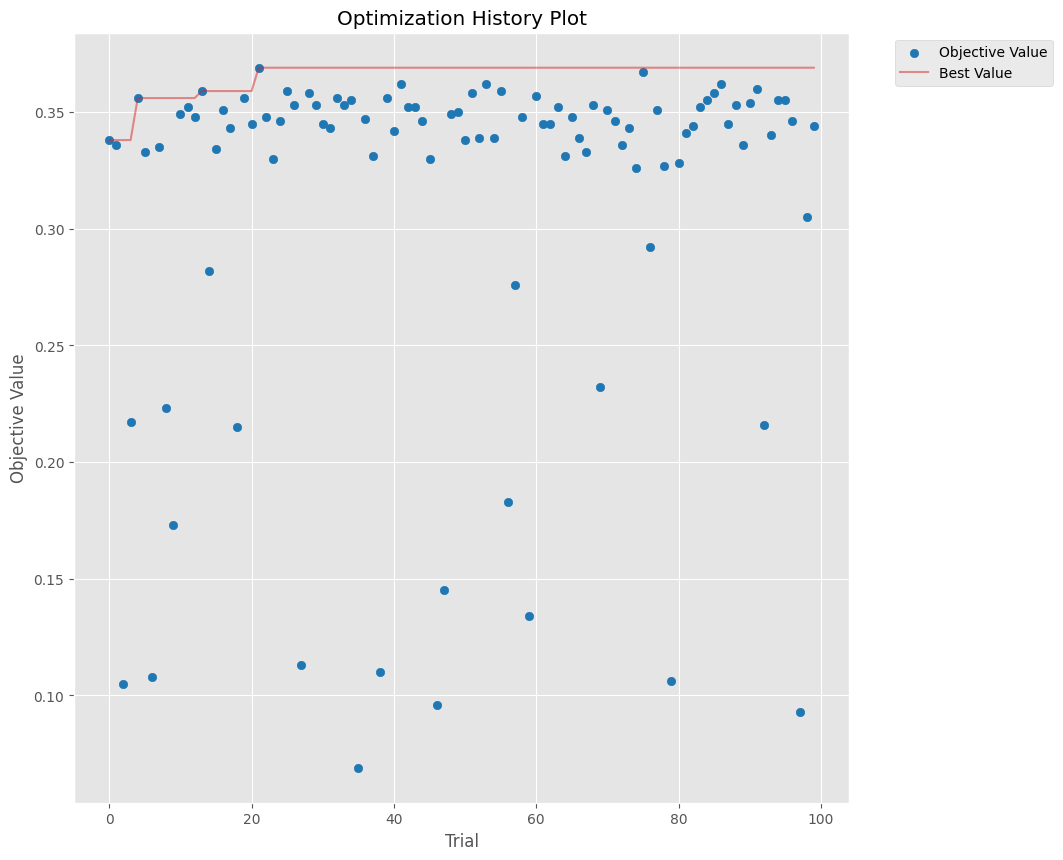

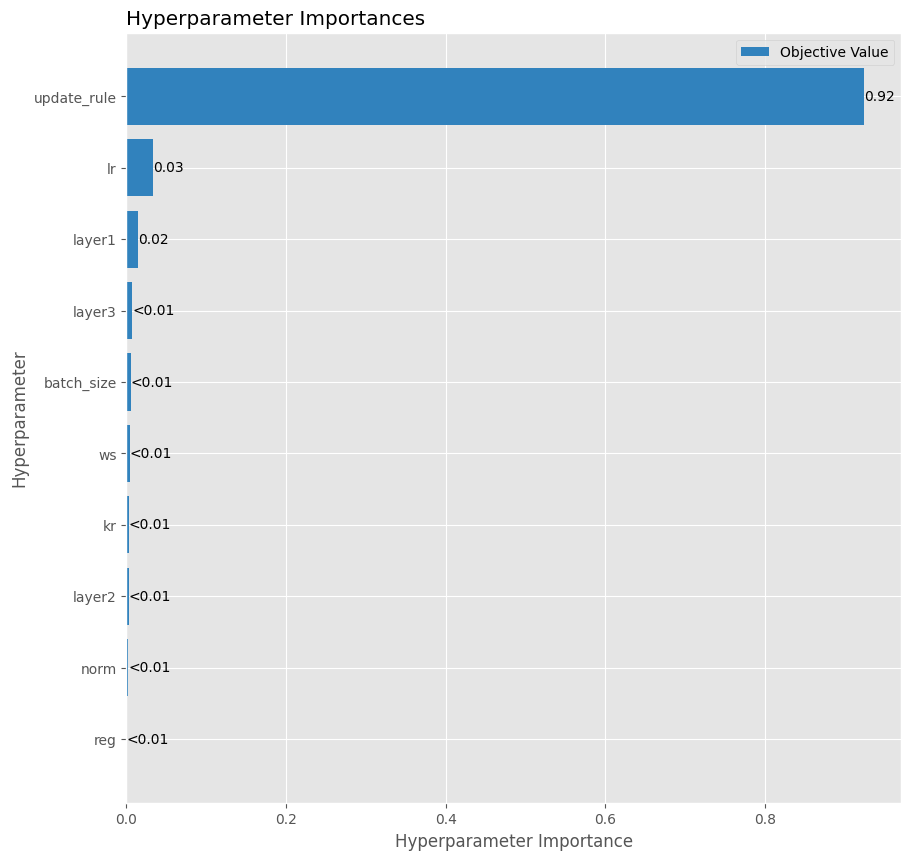

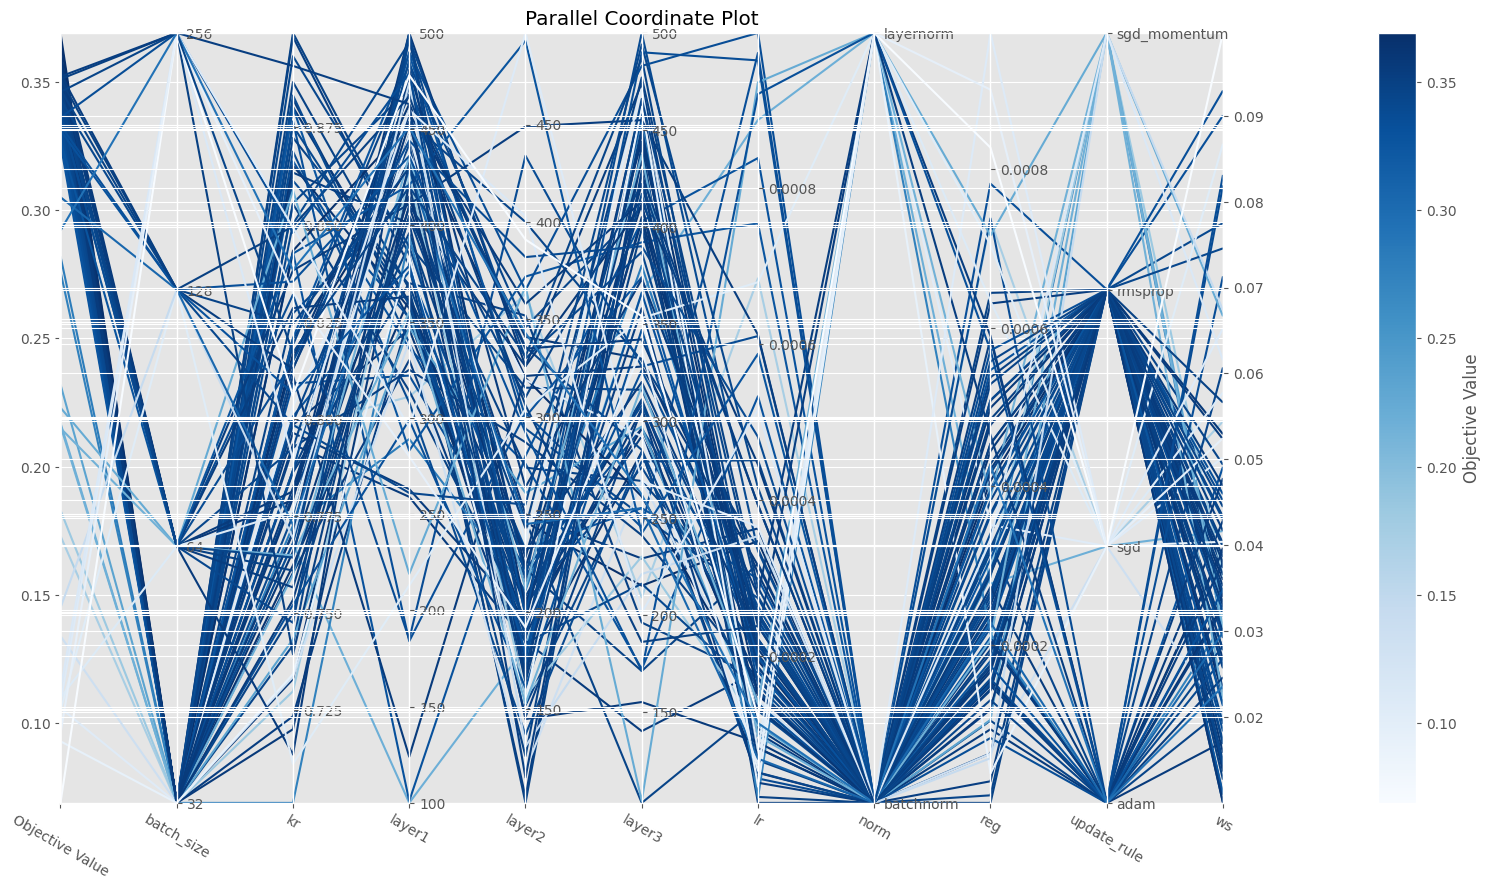

In [63]:
# 最適化履歴のプロット
optuna.visualization.matplotlib.plot_optimization_history(study)
# パラメータの重要度のプロット
optuna.visualization.matplotlib.plot_param_importances(study)
# パラメータの関係性をプロット
plt.rcParams["figure.figsize"] = (20, 10)
optuna.visualization.matplotlib.plot_parallel_coordinate(study)

最良のパラメータと正解率を出力

In [35]:
print(f"ベストパラメータ:{study.best_params}")
print(f"正解率:{study.best_value}")

ベストパラメータ:{'layer1': 431, 'layer2': 246, 'layer3': 215, 'lr': 0.0003471879064960782, 'ws': 0.0396766005958841, 'reg': 0.0001545981714921285, 'kr': 0.8167247483737552, 'norm': 'batchnorm', 'batch_size': 32, 'update_rule': 'adam'}
正解率:0.369


In [36]:
# 最適なパラメータで最適なモデルを作成
best_model_optuna = FullyConnectedNet(
    [
        study.best_params["layer1"],
        study.best_params["layer2"],
        study.best_params["layer3"],
    ],
    weight_scale=study.best_params["ws"],
    reg=study.best_params["reg"],
    dropout_keep_ratio=study.best_params["kr"],
    normalization=study.best_params["norm"],
)

# フルデータセットでモデルをトレーニングするソルバーを作成する。
solver_best_optuna = Solver(
    best_model_optuna,
    data,
    num_epochs=20,
    batch_size=study.best_params["batch_size"],
    update_rule=study.best_params["update_rule"],
    optim_config={"learning_rate": study.best_params["lr"]},
    verbose=False,
)

solver_best_optuna.train()  # 最適なモデルをトレーニングする

# 最良のモデルで得られた最終的な検証精度を出力する。
print(f"Best validation accuracy using full dataset: {solver_best_optuna.best_val_acc}")

Best validation accuracy using full dataset: 0.58


# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

最適なモデルを検証セットとテストセットで実行する。検証セットで少なくとも50％の精度を達成する必要があります。

In [14]:
y_test_pred = np.argmax(best_model.loss(data["X_test"]), axis=1)
y_val_pred = np.argmax(best_model.loss(data["X_val"]), axis=1)
print("Validation set accuracy: ", (y_val_pred == data["y_val"]).mean())
print("Test set accuracy: ", (y_test_pred == data["y_test"]).mean())

Validation set accuracy:  0.535
Test set accuracy:  0.525


Optunaでチューニングしたモデルのテスト

In [37]:
y_test_pred = np.argmax(best_model_optuna.loss(data["X_test"]), axis=1)
y_val_pred = np.argmax(best_model_optuna.loss(data["X_val"]), axis=1)
print("Validation set accuracy: ", (y_val_pred == data["y_val"]).mean())
print("Test set accuracy: ", (y_test_pred == data["y_test"]).mean())

Validation set accuracy:  0.569
Test set accuracy:  0.531
